# elipsoide de incertidumbre

Es un modelo muy simple pero extremadamente útil de una muestra multidimensional.

In [1]:
import numpy              as np
import numpy.linalg       as la
import cv2                as cv
import matplotlib.pyplot  as plt
import numpy.random       as rnd
from   mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Ejemplo con datos artificiales: generamos 100 puntos 2D aleatorios con distribución normal (`randn`) y los transformamos para obtener variables dependientes.

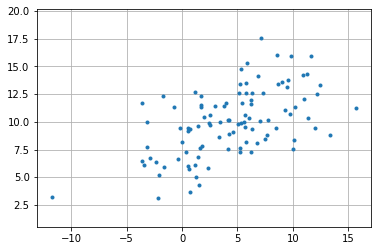

In [2]:
A = np.array([[5, 1],
              [2,-2]])
B = np.array([5,10])
x = rnd.randn(100,2) @ A.T + B    # x = Ar+B

plt.plot(x[:,0],x[:,1],'.');
plt.grid(); plt.axis('equal');

## matriz de covarianza

La muestra aleatoria multidimensional se puede caracterizar con la media y la matriz de covarianza:

In [3]:
m = np.mean(x,axis=0)
c = np.cov(x,rowvar=False)

print(m)
print(c)

[4.39898293 9.98826094]
[[21.88576474  7.88181437]
 [ 7.88181437  9.0179913 ]]


La desviaciones típicas de las variables originales están en la diagonal:

In [4]:
np.sqrt(np.diag(c))

array([4.67822239, 3.00299705])

Los coeficientes de covarianza son los elementos fuera de la diagonal, y a partir de ellos pueden obtenerse los [coeficientes de correlación lineal](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), cuyo valor, entre -1 y +1 indica el grado de dependencia lineal entre cada pareja de variables.

In [5]:
c[0,1]/(c[0,0]*c[1,1])

0.03993508966028899

Es importante recordar que la correlación lineal puede no detectar dependencias no lineales más complejas y que la correlación estadística no implica que exista una relación de causa-efecto entre las variables.

Las variables originales no siempre son las más adecuadas para describir un conjunto de datos. Es conveniente transformarlas para encontrar una representación más simple. Las [direcciones principales](https://en.wikipedia.org/wiki/Principal_component_analysis) son muy informativas: están descorreladas (son linealmente independientes) y pueden ordenarse de mayor a menor importancia. Se consiguen con [valores y vectores propios](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) de la matriz de covarianza. (Se trata simplemente de cambiar el sistema de referencia, girando los ejes.)

In [6]:
l,v = la.eigh(c)  # eigenvalues and eigenvectors de c, cuando c es simétrica.

print(np.sqrt(l))
print(v)

sl1 = np.sqrt(l[0])
sl2 = np.sqrt(l[1])
v1 = v[:,0]
v2 = v[:,1]

[2.29728177 5.0622379 ]
[[ 0.42874124 -0.90342733]
 [-0.90342733 -0.42874124]]


El conjunto de datos se resume mediante una elipse.

In [7]:
# para representar gráficamente la elipse de incertidumbre deformamos un círculo

cir = np.array([ [np.cos(t), np.sin(t)] for t in np.linspace(0,2*np.pi, 40) ])

def rot(a):
    c = np.cos(a)
    s = np.sin(a)
    return np.array([[c,-s],
                     [s, c]])

def ellip(mx,my,s1,s2,a):
    return np.array([mx,my]) + cir @ np.diag([s1,s2]) @ rot(-a)

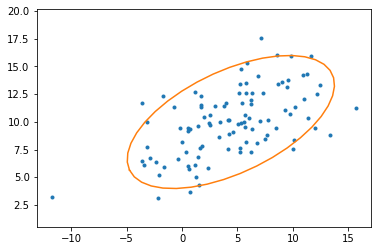

In [8]:
plt.plot(x[:,0],x[:,1],'.'); plt.axis('equal');
e = ellip(m[0],m[1],2*sl2,2*sl1,np.arctan2(v2[1],v2[0]))
plt.plot(e[:,0],e[:,1]);

### distancia normalizada

(pendiente)

Aquí vemos una representación de la distribución de probabilidad como curvas de nivel y las direcciones principales. Es la elipse de incertidumbre a una, dos, y 3 desviaciones.

In [9]:
def distMah(m,ic,v):
    return np.sqrt((v-m) @ ic @ (v-m))

In [10]:
# auxliar para poder hacer un contour plot
def dm(m,c):
    ic = la.inv(c)
    f = lambda x,y: distMah(m,ic,np.array([x,y]))
    return np.vectorize(f)

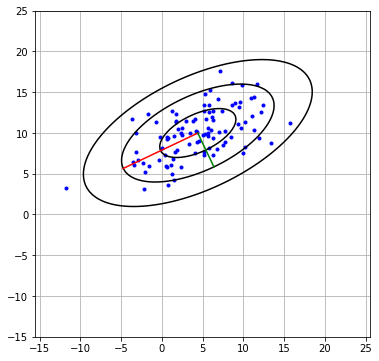

In [11]:
r = np.linspace(-15,25,100)
x1,x2 = np.meshgrid(r,r)

plt.figure(figsize=(6,6))

plt.plot(x[:,0],x[:,1],'b.');
plt.contour(x1,x2, dm(m,c)(x1,x2), [1,2,3], colors=['k']);

plt.plot([m[0],m[0]+v2[0]*2*sl2],[m[1],m[1]+v2[1]*2*sl2], 'r')
plt.plot([m[0],m[0]+v1[0]*2*sl1],[m[1],m[1]+v1[1]*2*sl1], 'g')

plt.grid(); plt.axis('equal');

Y aquí tenemos la densidad de probabilidad:

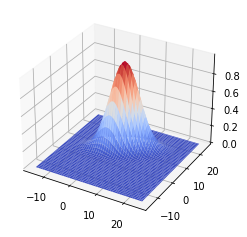

In [12]:
y = np.exp(-0.5*dm(m,c)(x1,x2)**2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1,x2,y, cmap="coolwarm", linewidth=0.5, rstride=2, cstride=2);

El elipsoide de incertidumbre es equivalente a suponer un modelo normal (Gaussiano) de los datos. Muy simple pero a la vez muy potente.

### aplicaciones

- distancia normalizada, clasificadores sencillos

- componentes principales, reducción de dimensión

- inferencia Bayesiana en modelos gaussianos, filtro de Kalman, gaussian processes

- modelos de mezcla

## computación a partir de un array

En el ejemplo anterior hemos calculado la elipse de incertidumbre a partir de un conjunto de puntos (una muestra de la variable aleatoria de interés). Pero también puede interesarnos un modelo gaussiano para representar una región 2D en la que cada punto $f(x,y)$ puede ser 0 ó 1 (una máscara) o la verosimilitud ($f(x) \geq 0$) de una cierta propiedad, o una probabilidad.

El modelo elíptico a partir de una imagen general (no máscara) es útil para encontrar la región de máxima respuesta a un determinado detector, por ejemplo en el tracking por modelos de color usando reproyección de histograma.

In [13]:
def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

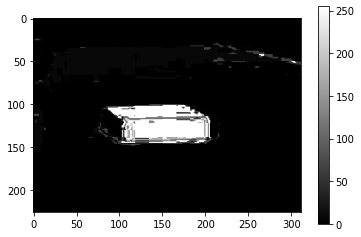

In [14]:
img = readrgb('reproh.png')
f = rgb2gray(img)
plt.imshow(f,'gray'); plt.colorbar();

Para encontrar un modelo elíptico de esa región, o sea, un modelo gaussiano de la distribución de probabilidad de la "intensidad de luz", utilizamos los *momentos* de la imagen:

$$m_{pq} \equiv \sum_{x,y} f(x,y) x^p y^q $$

A partir de ellos podemos calcular la media y matriz de covarianza de la región.

In [15]:
def medcov(c):
    m = cv.moments(c.astype(np.float32))  # int32, float32, but not float64! (for contours)
    s = m['m00']
    return (m['m10']/s, m['m01']/s, m['mu20']/s, m['mu02']/s, m['mu11']/s)

[23.07474569 39.37014786]
[[-0.05910331 -0.99825187]
 [-0.99825187  0.05910331]]


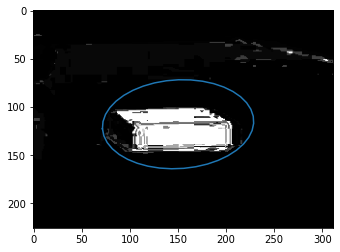

In [16]:
mx,my,cxx,cyy,cxy = medcov(f)

c = np.array([[cxx,cxy],
              [cxy,cyy]])

l,v = la.eigh(c)

print(np.sqrt(l))
print(v)

sl1 = np.sqrt(l[0])
sl2 = np.sqrt(l[1])
v1 = v[:,0]
v2 = v[:,1]

plt.imshow(f,'gray');
e = ellip(mx,my,2*sl2,2*sl1,np.arctan2(v2[1],v2[0]))
plt.plot(e[:,0],e[:,1]);

La elipse no se ajusta perfectamente a la región porque se ha calculado con las intensidades en toda la imagen y hay "outliers" cerca de la esquina superior derecha. Si se recalcula dando menos peso a los puntos más alejados conseguimos un modelo mucho mejor (el método de tracking *camshift* se basa en esta idea).

La elipse de incertidumbre puede obtenerse también a partir de una máscara (imagen booleana):

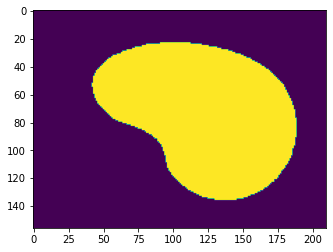

In [17]:
img = readrgb('patata.png')
f = rgb2gray(img) < 128

plt.imshow(f);

In [18]:
mx,my,cxx,cyy,cxy = medcov(f)

c = np.array([[cxx,cxy],
              [cxy,cyy]])

l,v = la.eigh(c)

print(np.sqrt(l))
print(v)

sl1 = np.sqrt(l[0])
sl2 = np.sqrt(l[1])
v1 = v[:,0]
v2 = v[:,1]

[24.64948714 38.22659038]
[[ 0.47967663 -0.87744534]
 [-0.87744534 -0.47967663]]


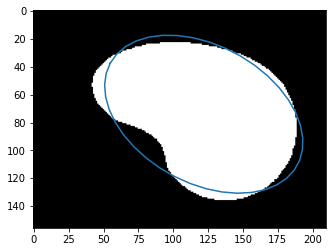

In [19]:
plt.imshow(f,'gray');
e = ellip(mx,my,2*sl2,2*sl1,np.arctan2(v2[1],v2[0]))
plt.plot(e[:,0],e[:,1]);

Cuando la región es una máscara y solo tiene una componente conexa los momentos se pueden calcular de forma más eficiente a partir únicamente del contorno de la figura. Para ello se utiliza un versión discreta del [Teorema de Green](https://en.wikipedia.org/wiki/Green%27s_theorem).

In [20]:
contours,_ = cv.findContours(f.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print(len(contours))

1


In [21]:
medcov(contours[0])

(121.90764000237543,
 74.00855157669696,
 1248.6413152273722,
 791.2967081520837,
 356.5579413765457)

In [22]:
medcov(f)

(121.87030058715274,
 73.9999123652616,
 1264.8504114336147,
 804.019016730555,
 359.3032924634634)

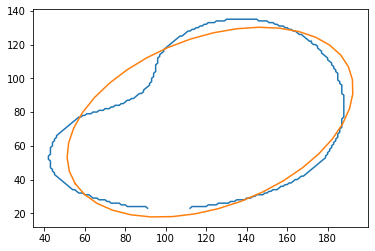

In [23]:
mx,my,cxx,cyy,cxy = medcov(contours[0])
c = np.array([[cxx,cxy],
              [cxy,cyy]])

l,v = la.eigh(c)

sl1 = np.sqrt(l[0])
sl2 = np.sqrt(l[1])
v1 = v[:,0]
v2 = v[:,1]

plt.plot(contours[0][:,:,0],contours[0][:,:,1]);
e = ellip(mx,my,2*sl2,2*sl1,np.arctan2(v2[1],v2[0]))
plt.plot(e[:,0],e[:,1]);

**Ejercicio**: Deduce una fórmula sencilla para calcular el área de un polígono a partir de las coordenadas de sus vértices.